In [1]:
import sys
import sklearn
import numpy as np
import pandas as pd
from time import time
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn import linear_model

f"Python: {sys.version}"

'Python: 3.7.3 (default, Mar 27 2019, 22:11:17) \n[GCC 7.3.0]'

### Setup

In [2]:
# trainData = pd.read_csv("tcdml1920-rec-click-pred--training.csv", index_col='recommendation_set_id', low_memory=False)
# testData = pd.read_csv("tcdml1920-rec-click-pred--test.csv", index_col='recommendation_set_id', low_memory=False)

trainData = pd.read_csv("tcdml1920-rec-click-pred--training.csv", low_memory=False)
testData = pd.read_csv("tcdml1920-rec-click-pred--test.csv", low_memory=False)
testData.dropna(how="all", inplace=True)

In [3]:
pd.set_option('display.max_columns', 50)
trainData.sample(5)

,recommendation_set_id,user_id,session_id,query_identifier,query_word_count,query_char_count,query_detected_language,query_document_id,document_language_provided,year_published,number_of_authors,abstract_word_count,abstract_char_count,abstract_detected_language,first_author_id,num_pubs_by_first_author,organization_id,application_type,item_type,request_received,hour_request_received,response_delivered,rec_processing_time,app_version,app_lang,user_os,user_os_version,user_java_version,user_timezone,country_by_ip,timezone_by_ip,local_time_of_request,local_hour_of_request,number_of_recs_in_set,recommendation_algorithm_id_used,algorithm_class,cbf_parser,search_title,search_keywords,search_abstract,time_recs_recieved,time_recs_displayed,time_recs_viewed,clicks,ctr,set_clicked
127157,191630,\N,\N,Withheld for privacy,13,98,en,103035781,\N,2017,3,220,1581,en,236082,139,1,digital_library,academic_publication,23/04/2019 15:27,15,23/04/2019 15:28,9.840970,4.3.1,en,\N,\N,\N,\N,BR,-300,23/04/2019 10:27,10,7,7,content_based_filtering,standard_QP,yes,yes,no,\N,\N,\N,0,0.0,0
218039,284692,\N,\N,Toshiba Laptop Satellite C850-13D Compatible P...,10,70,en,123993130,\N,\N,\N,115,766,en,\N,\N,4,e-commerce,Home entertainment,03/07/2019 07:32,7,03/07/2019 07:32,0.056557,\N,en,\N,\N,\N,\N,DE,\N,\N,\N,3,11,content_based_filtering,edismax_QP,yes,no,no,\N,\N,\N,0,0.0,0
100774,161542,\N,\N,Withheld for privacy,7,55,en,20161495,\N,2011,4,103,715,en,6078565,7,1,digital_library,academic_publication,25/03/2019 20:47,20,25/03/2019 20:47,10.853200,4.3.1,en,\N,\N,\N,\N,BR,-300,25/03/2019 16:47,16,7,7,content_based_filtering,standard_QP,yes,yes,no,\N,\N,\N,0,0.0,0
336635,407651,\N,\N,Withheld for privacy,14,93,en,\N,\N,\N,\N,\N,\N,\N,\N,\N,1,digital_library,academic_publication,11/09/2019 16:38,16,11/09/2019 16:38,13.875100,4.3.1,en,\N,\N,\N,\N,DK,200,11/09/2019 16:38,16,7,27,sentence_embeddings,\N,no,no,no,\N,\N,\N,0,0.0,0
115142,178435,\N,\N,Withheld for privacy,1,8,sv,\N,\N,\N,\N,\N,\N,\N,\N,\N,1,digital_library,academic_publication,09/04/2019 22:09,22,09/04/2019 22:09,3.673200,4.3.1,en,\N,\N,\N,\N,PL,200,09/04/2019 22:09,22,7,8,content_based_filtering,standard_QP,yes,yes,yes,\N,\N,\N,0,0.0,0


In [4]:
trainData.replace(["\\N", "nA", "Not provided", "unknown", "*unknown*"], np.nan, inplace=True)
testData.replace(["\\N", "nA", "Not provided",  "unknown", "*unknown*"], np.nan, inplace=True)

In [5]:
# trainData.isnull().sum().sort_values()

In [6]:
numeric_columns = [
    "query_word_count",
    "query_char_count",
    "query_document_id",
    "year_published",
    "number_of_authors",
    "abstract_char_count",
    "abstract_word_count",
    "first_author_id",
    "num_pubs_by_first_author",
    "hour_request_received",
    "local_hour_of_request",
    "recommendation_algorithm_id_used",
    "clicks",
]

In [7]:
time_columns = [
    "request_received",
    "response_delivered",
    "local_time_of_request",
    "time_recs_recieved",
    "time_recs_displayed",
    "time_recs_viewed",
]

In [8]:
for col in numeric_columns:
    trainData[col] = pd.to_numeric(trainData[col], errors="coerce")
    testData[col] = pd.to_numeric(testData[col], errors="coerce")

In [9]:
for col in time_columns:
    trainData[col] = pd.to_datetime(trainData[col], format="%d/%m/%Y %H:%M")
    testData[col] = pd.to_datetime(testData[col], format="%d/%m/%Y %H:%M")

In [10]:
pd.set_option('display.max_columns', 500)
pd.set_option('display.max_rows', 5)
trainData["query_document_id"].value_counts()

124015831.0    2004
124015835.0    1589
               ... 
12146053.0        1
16778331.0        1
Name: query_document_id, Length: 63780, dtype: int64

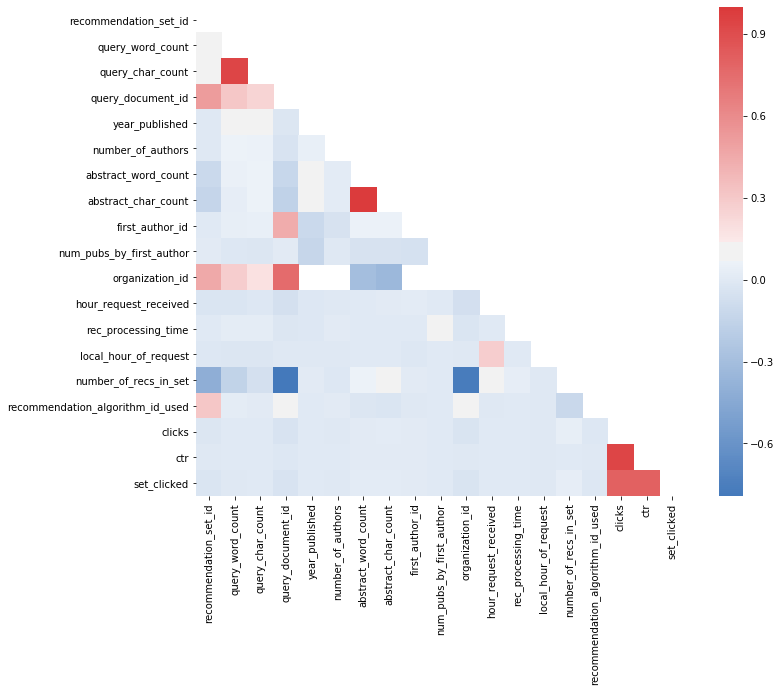

In [11]:
corrmat = trainData.corr()
mask = np.zeros_like(corrmat, dtype=np.bool)
mask[np.triu_indices_from(mask)] = True
f, ax = plt.subplots(figsize=(12, 9))
cmap = sns.diverging_palette(250, 12, as_cmap=True)
sns.heatmap(corrmat,mask=mask,cmap=cmap, vmax=1, square=True);

In [12]:
trainData.columns

Index(['recommendation_set_id', 'user_id', 'session_id', 'query_identifier',
       'query_word_count', 'query_char_count', 'query_detected_language',
       'query_document_id', 'document_language_provided', 'year_published',
       'number_of_authors', 'abstract_word_count', 'abstract_char_count',
       'abstract_detected_language', 'first_author_id',
       'num_pubs_by_first_author', 'organization_id', 'application_type',
       'item_type', 'request_received', 'hour_request_received',
       'response_delivered', 'rec_processing_time', 'app_version', 'app_lang',
       'user_os', 'user_os_version', 'user_java_version', 'user_timezone',
       'country_by_ip', 'timezone_by_ip', 'local_time_of_request',
       'local_hour_of_request', 'number_of_recs_in_set',
       'recommendation_algorithm_id_used', 'algorithm_class', 'cbf_parser',
       'search_title', 'search_keywords', 'search_abstract',
       'time_recs_recieved', 'time_recs_displayed', 'time_recs_viewed',
       'clicks', 

In [13]:
# pd.options.display.float_format = 'describef}'.format
trainData["query_detected_language"].value_counts()

en    315664
de     34999
       ...  
el         1
uk         1
Name: query_detected_language, Length: 39, dtype: int64

In [14]:
# Row Duplication check TrainData
duplicateRowsTrain = trainData[trainData.duplicated()]
duplicateRowsTrain.shape

(0, 46)

285 Duplicated train rows

In [15]:
# Row Duplication check TestData
duplicateRowsTest = testData[testData.duplicated()]
duplicateRowsTest.shape

(0, 46)

### Basic visualizations

In [ ]:
plt.figure(figsize=(24, 4))
# sns.countplot(x="query_identifier", data=train_set)
# plt.show()
sns.countplot(x="document_language_provided", data=train_set)
plt.show()
plt.figure(figsize=(24, 4))
sns.countplot(x="abstract_detected_language", data=train_set)
plt.show()
sns.countplot(x="application_type", data=train_set)
plt.show()
plt.figure(figsize=(24, 4))
sns.countplot(x="item_type", data=train_set)
plt.show()
plt.figure(figsize=(24, 4))
sns.countplot(x="app_version", data=train_set, order=pd.value_counts(
    train_set['app_version']).iloc[:10].index)
plt.show()
sns.countplot(x="app_lang", data=train_set)
plt.show()
sns.countplot(x="user_os", data=train_set)
plt.show()
# sns.countplot(x="user_os_version", data=train_set)
# plt.show()
# sns.countplot(x="user_java_version", data=train_set)
# plt.show()
plt.figure(figsize=(24, 4))
sns.countplot(x="user_timezone", data=train_set,
              order=pd.value_counts(train_set['user_timezone']).index)
plt.show()
plt.figure(figsize=(24, 4))
sns.countplot(x="country_by_ip", data=train_set, order=pd.value_counts(
    train_set['country_by_ip']).iloc[:15].index)
plt.show()
plt.figure(figsize=(24, 4))
sns.countplot(x="timezone_by_ip", data=train_set, order=pd.value_counts(
    train_set['timezone_by_ip']).iloc[:15].index)
plt.show()
plt.figure(figsize=(24, 4))
sns.countplot(x="algorithm_class", data=train_set)
plt.show()

### Encoding
- One hot
- Target

- Smote 
- Giving more weight to yes